<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Interpretation3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the third dataset

In [3]:
#@title
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

!pip install shap 
import shap

!pip install pytorch-gradcam
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/cam.py -P local_modules -nc
!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/utils/visualize.py -P local_modules -nc
import sys
sys.path.append('local_modules')
from PIL import Image
from local_modules.visualize import visualize
import local_modules.cam as smooth

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/Hshapley2.py -P local_modules -nc
import local_modules.Hshapley2 as HS

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/utils.py -P local_modules -nc
import local_modules.utils as utils

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/interpret11.py -P local_modules -nc
import local_modules.interpret11 as intp

torch.manual_seed(0)

dtype = torch.float

FIGSIZE = (5,4)

net = utils.Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model3.pth')) 

data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data3/data.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

Batch_Size = 64
#transf_temp =  transforms.Compose( [ToTensor()])
#train_data_temp = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf_temp)
#dataloader_temp = DataLoader(train_data_temp, batch_size = Batch_Size, shuffle = True, num_workers = 0)
#MEAN, STD = utils.datasetMeanStd(dataloader_temp)
MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

transf = transforms.Compose( [ToTensor(), Normalize(mean=MEAN, std=STD)])

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = Batch_Size, shuffle = False, num_workers = 0)
train_loader = iter(dataloader)


ImF = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/data3", transform = transf)
batch_Size = 3
exloader = DataLoader(ImF, batch_size = batch_Size, shuffle = False, num_workers = 0)

exIter = iter(exloader)
images, labels = next(exIter)

# For guided backprop
backprop = Backprop(net)

# For SHAP
X,Y = next(train_loader)
bg_choice = None # Default: entire training set, "average", "white", "black" 
# Median would result in white 
background = X
if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)
e = shap.GradientExplainer(net, background)

# For GradCAM
gradcam_conv = GradCAM(net, net.conv2)
gradcam_pp_conv = GradCAMpp(net, net.conv2)
gradcam_pool = GradCAM(net, net.pool2)
gradcam_pp_pool = GradCAMpp(net, net.pool2)

# For SmoothCAM
target_layer = net.conv2
wrapped_G = smooth.GradCAM(net, target_layer)
wrapped_P = smooth.GradCAMpp(net, target_layer)
wrapped_S = smooth.SmoothGradCAMpp(net, target_layer, n_samples=25, stdev_spread=0.15)
wrapped = [wrapped_G, wrapped_P, wrapped_S]

# For Hierarchical Shapley
h = HS.HierarchicalShap(net)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
  Created wheel for flashtorch: filename=flashtorch-0.1.2-cp36-none-any.whl size=26236 sha256=a0efe7c37807a15d3927290d2866491cdff218a8726aff4cddc73cba8e19c228
  Stored in directory: /root/.cache/pip/wheels/91/44/8e/c33cc10ab8d0f24036e82f0e475277dc4a479cd3fb03329a39
Successfully built flashtorch
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394110 sha256=ab074ebc57de736002


# EXAMPLE 0

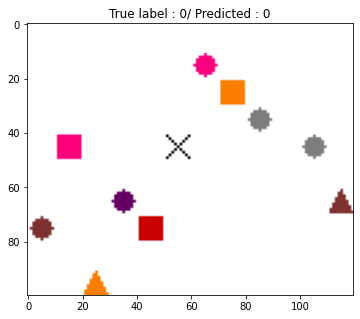

In [4]:
image0 = images[0]
label0 = labels[0]

input0 = image0.view(-1, 3, 100, 120) # This shape is necessary for the network 
output0 = net(input0)
_, predicted0 = torch.max(output0.data, 1)

img0 = utils.input2image(image0, MEAN, STD)
utils.display_image(img0, label0.numpy(), int(predicted0))

### Guided backpropagation explanation

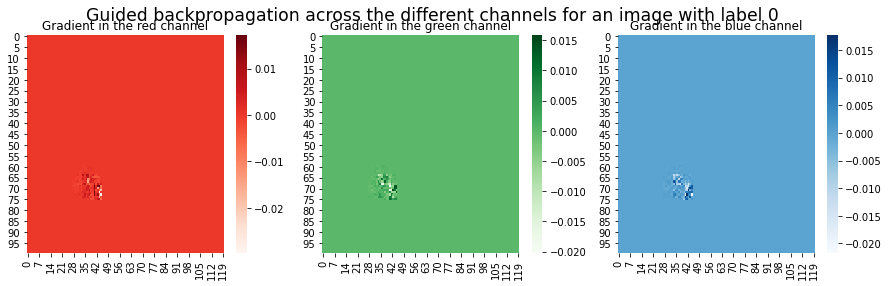

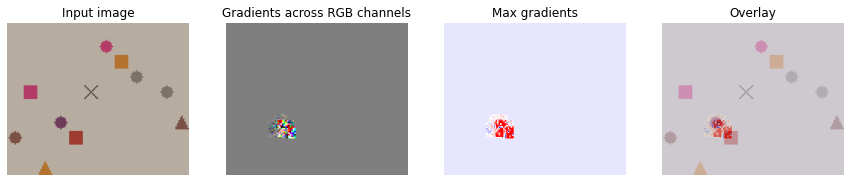

In [5]:
input0.requires_grad = True # Necessary to compute the gradient
gradients0 = backprop.calculate_gradients(input0, label0, guided = True).detach().numpy()
intp.display_gradients(gradients0, FIGSIZE).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");
backprop.visualize(input0, label0, guided=True, figsize = (3*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

### Shapley explanation

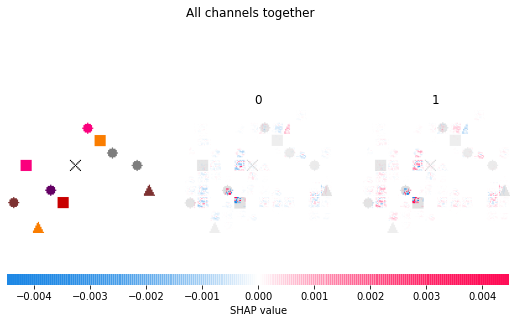

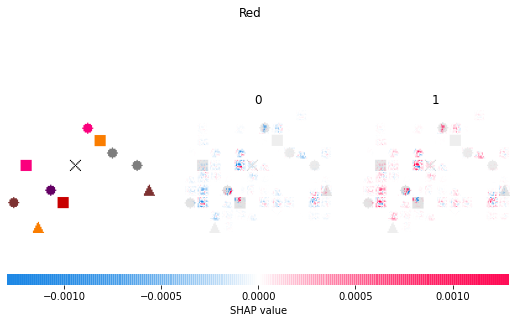

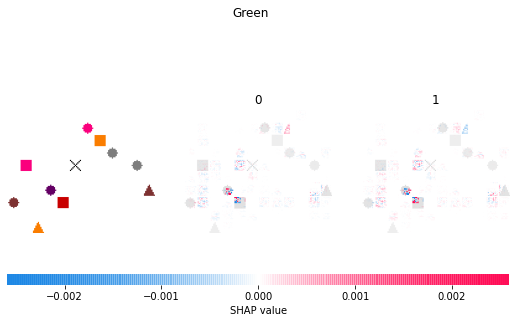

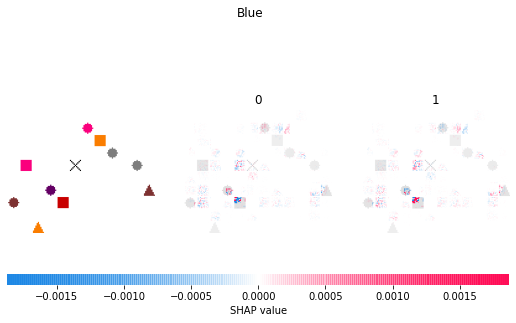

In [6]:
intp.shap_exp(e, input0.detach(), img0)

### GradCAM explanation

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


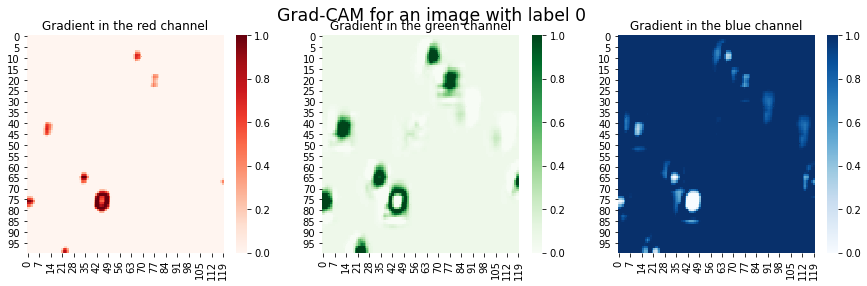

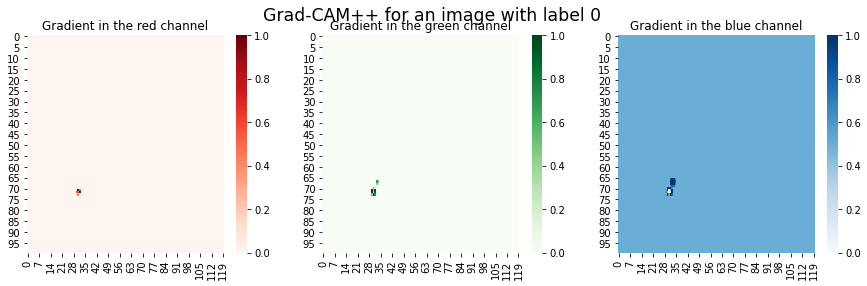

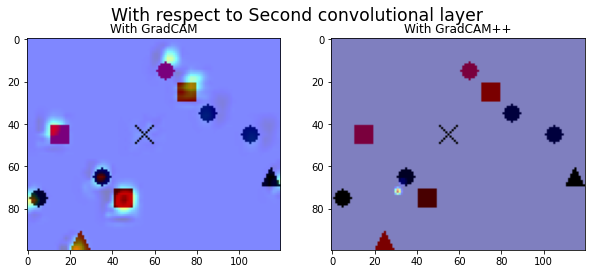

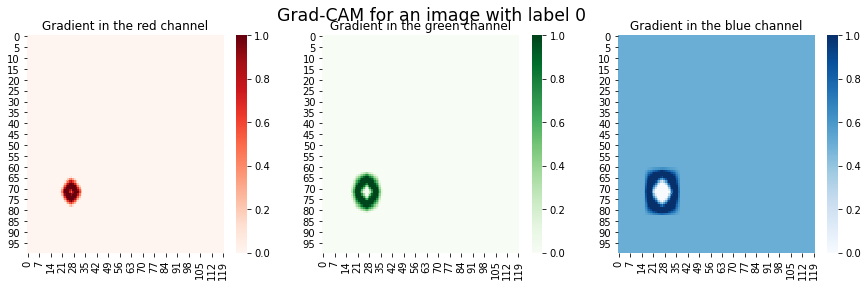

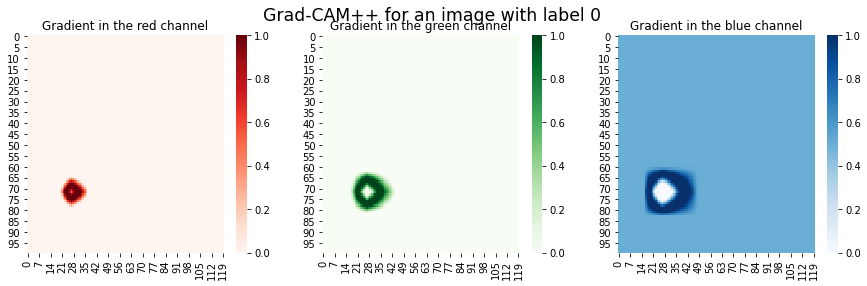

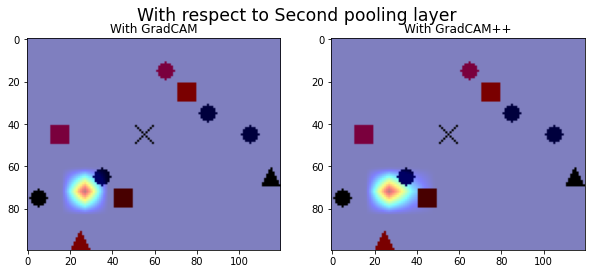

In [7]:
intp.gradcam_exp(gradcam_conv, gradcam_pp_conv, input0, img0,  "Second convolutional layer", FIGSIZE)
intp.gradcam_exp(gradcam_pool, gradcam_pp_pool, input0, img0,  "Second pooling layer", FIGSIZE)

### SmoothCAM explanation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 0	 probability 0.9995954632759094
predicted class ids 0	 probability 0.9995954632759094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 0	 probability 0.9995980858802795


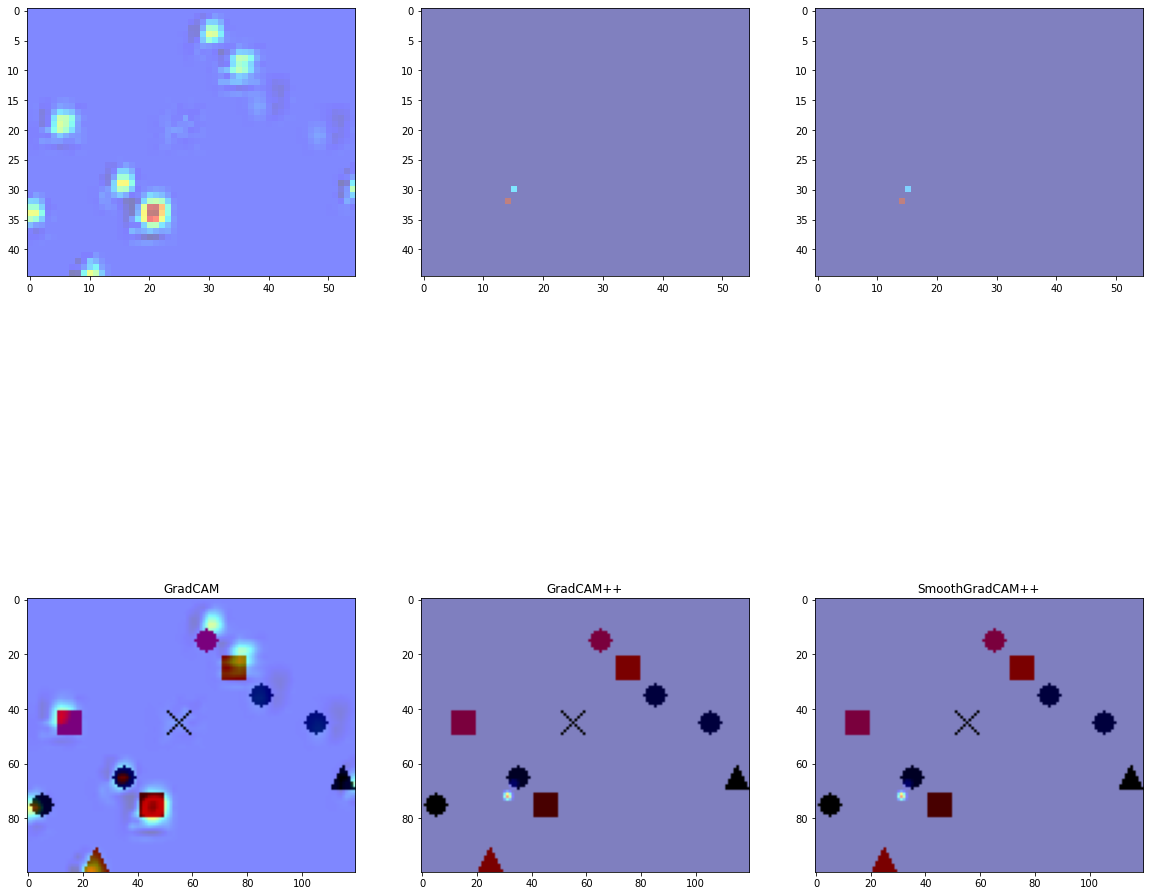

In [8]:
intp.smooth_exp(input0, image0, wrapped)

### Hierarchical Shapley explanation

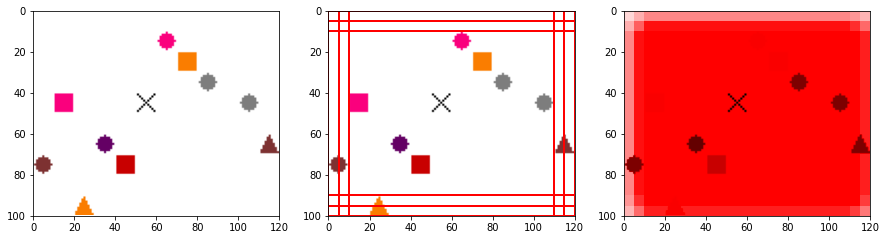

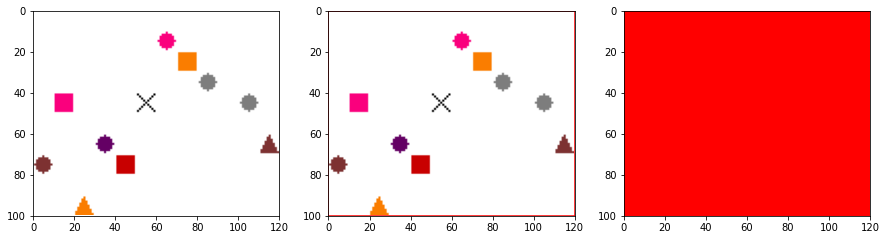

In [9]:
h.shapMap(image0, label0, shapTol = [5,5.5,6,6.5,7])
h.shapMap(image0, label0, shapTol = [6], keepItSimple = True)

# EXAMPLE 1

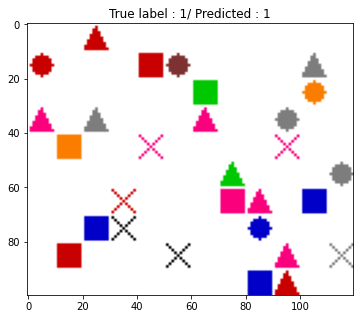

In [10]:
image1 = images[1]
label1 = labels[1]

input1 = image1.view(-1, 3, 100, 120)
output1 = net(input1)
_, predicted1 = torch.max(output1.data, 1)

img1 = utils.input2image(image1, MEAN, STD)
utils.display_image(img1, label1.numpy(), int(predicted1))

### Backpropagation

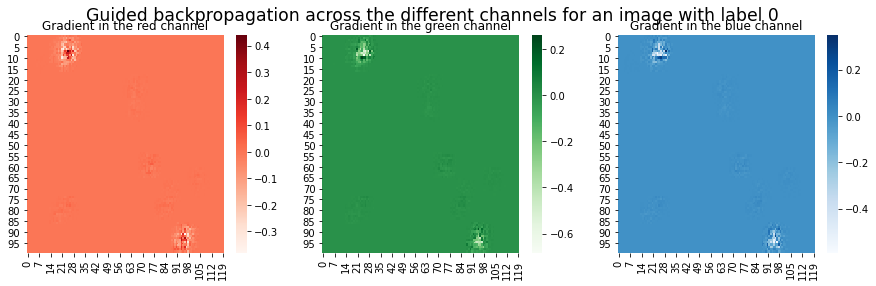

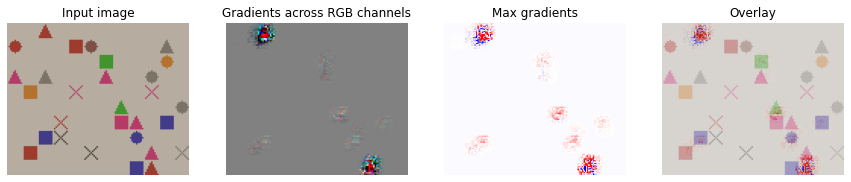

In [11]:
input1.requires_grad = True # Necessary to compute the gradient
gradients1 = backprop.calculate_gradients(input1, label1, guided = True).detach().numpy()
intp.display_gradients(gradients1, FIGSIZE).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");
backprop.visualize(input1, label1, guided=True, figsize = (3*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

### Shapley explanation

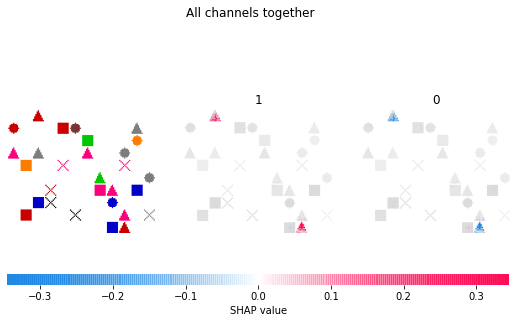

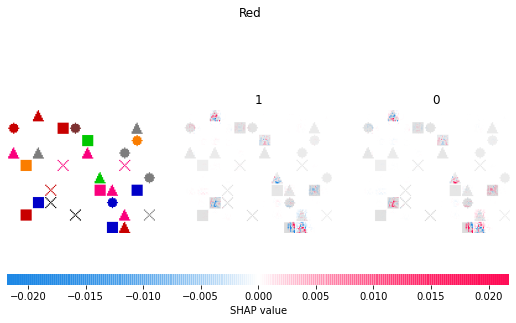

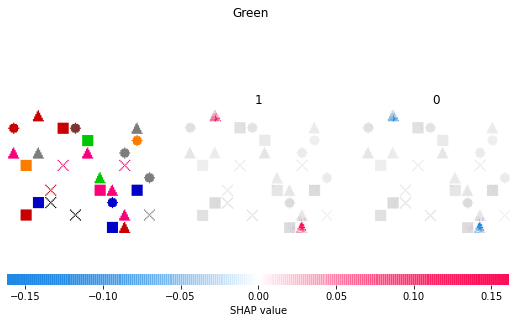

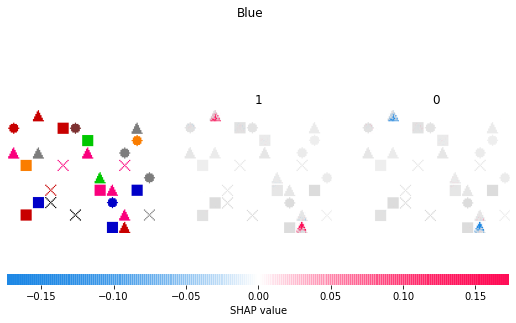

In [12]:
intp.shap_exp(e, input1.detach(), img1)

### GradCAM

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


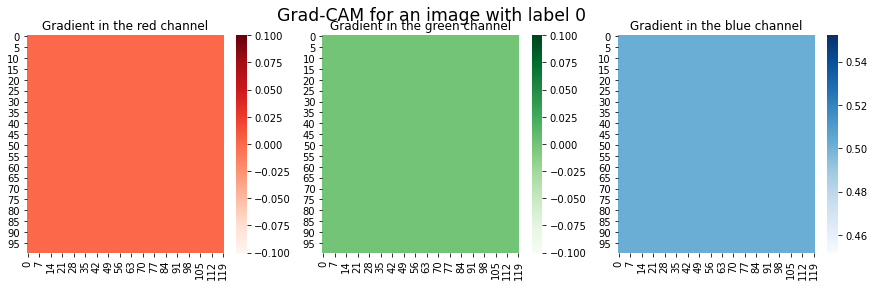

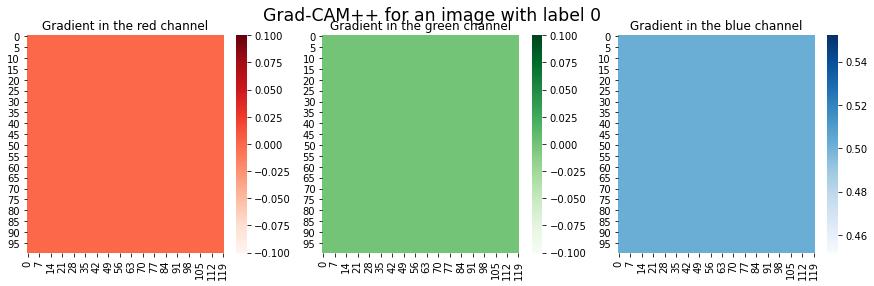

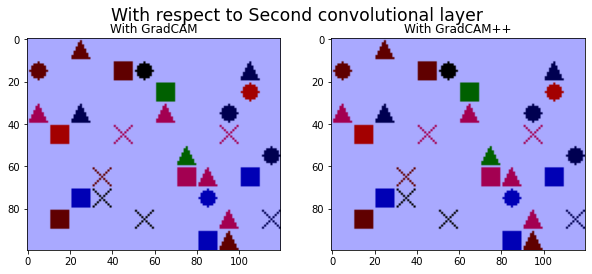

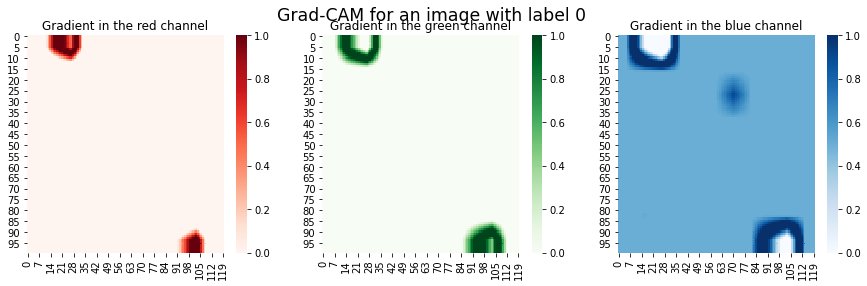

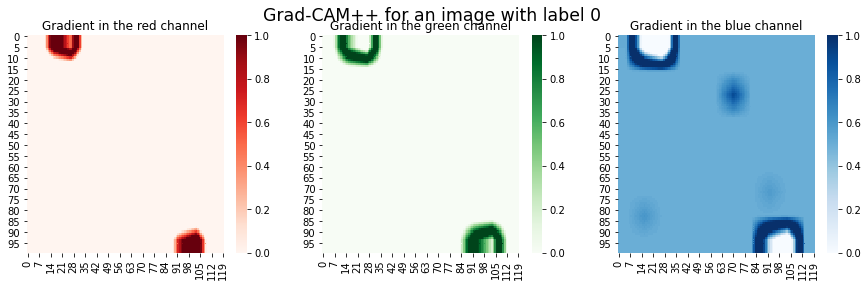

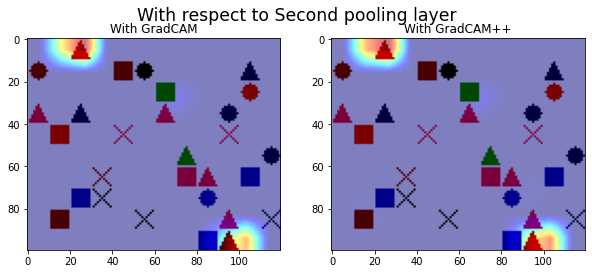

In [13]:
intp.gradcam_exp(gradcam_conv, gradcam_pp_conv, input1, img1,  "Second convolutional layer", FIGSIZE)
intp.gradcam_exp(gradcam_pool, gradcam_pp_pool, input1, img1,  "Second pooling layer", FIGSIZE)

### SmoothCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 1	 probability 1.0
predicted class ids 1	 probability 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 1	 probability 1.0


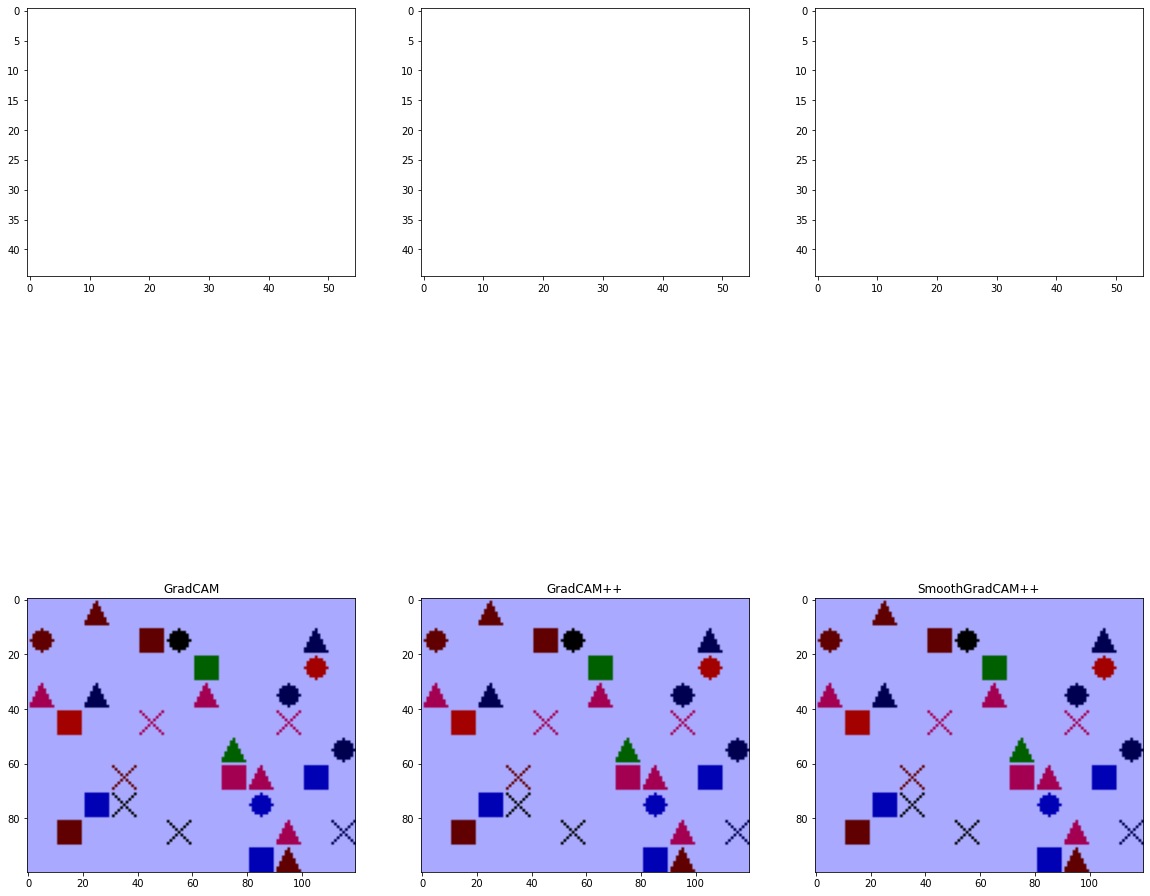

In [14]:
intp.smooth_exp(input1, image1, wrapped)

### Hierarchical Shapley

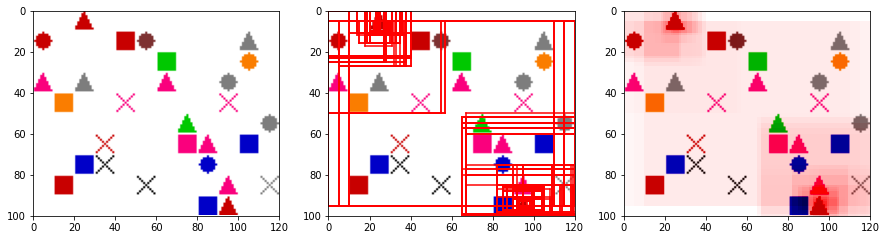

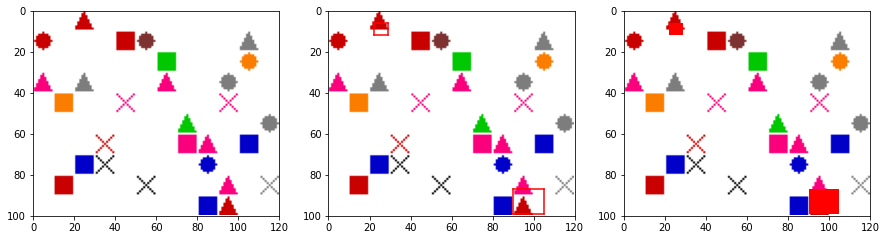

In [15]:
h.shapMap(image1, label1, shapTol = [5,5.5,6,6.5,7])
h.shapMap(image1, label1, shapTol = [6], keepItSimple = True)